# SysArmy - Análisis de encuesta 2020.01

## 1. Carga y sanitización de datos

###  1.1. Definimos los metadatos asociados al dataset que vamos a analizar

In [1]:
csv_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTORpz5hc_wOwKdaKEIgVOAI3XVTh9WXB__C2abe_E0aJoYIoqhWQ-HTpBBryAByhIlX_booioqxK0T/pub?gid=1893349211&single=true&output=csv';

dataset_metadata = {
  'year': 2019,
  'part': 2,
  'skiprows': 0,
  'publish_date': '2019-08-15',
  'minimum_salary': 12500, # https://es.wikipedia.org/wiki/Anexo:Salario_m%C3%ADnimo_en_Argentina
}

### 1.2. En base a los metadatos, cargamos el CSV, limpiamos columnas y las transformamos

In [2]:
import pandas as pd
import io
import requests
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:

raw_dataframe = None
#source = requests.get(csv_url.format(dataset_metadata['year'], dataset_metadata['part'])).content
raw_dataframe = pd.read_csv(io.StringIO(source.decode('utf-8')), skiprows=dataset_metadata['skiprows'], thousands='.', decimal=',')

# resultados que no pertenezcan a Argentina quedan fuera de este análisis
columns_to_remove = [
    'Bolivia', 'Chile', 'Colombia', 'Cuba',
    'Costa Rica', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras',
    'México', 'Nicaragua', 'Panamá', 'Paraguay', 'Perú', 'Puerto Rico',
    'República Dominicana', 'Uruguay', 'Venezuela']

raw_dataframe.drop(columns_to_remove, axis = 1, inplace = True)

import re
regex_white_chars = re.compile(r'\s+')
regex_non_alphanum = re.compile(r'\W+_?', re.I)

raw_dataframe.columns = raw_dataframe.columns \
  .str.strip() \
  .str.lower() \
  .str.replace(regex_white_chars, '_') \
  .str.replace(regex_non_alphanum, '') \
  .str.translate("ñáéíóú".maketrans({'ñ': 'n', 'á': 'a', 'é':'e', 'í':'i', 'ó':'o', 'ú': 'u'}))

dataframe = raw_dataframe.copy()

display([column for column in dataframe.columns])

['timestamp',
 'me_identifico',
 'tengo',
 'estoy_trabajando_en',
 'donde_estas_trabajando',
 'anos_de_experiencia',
 'anos_en_la_empresa_actual',
 'anos_en_el_puesto_actual',
 'gente_a_cargo',
 'nivel_de_estudios_alcanzado',
 'estado',
 'carrera',
 'universidad',
 'realizaste_cursos_de_especializacion',
 'contribuis_a_proyectos_open_source',
 'programas_como_hobbie',
 'trabajo_de',
 'plataformas',
 'lenguajes_de_programacion',
 'frameworksherramientas_y_librerias',
 'bases_de_datos',
 'qa_testing',
 'ides',
 'que_so_usas_en_tu_laptoppc_para_trabajar',
 'y_en_tu_celular',
 'tenes_guardias',
 'cuanto_cobras_por_guardia',
 'porcentajebruto_o_neto',
 'tipo_de_contrato',
 'salario_mensual_bruto_en_tu_moneda_local',
 'salario_mensual_neto_en_tu_moneda_local',
 'que_tan_conforme_estas_con_tu_sueldo',
 'como_crees_que_esta_tu_sueldo_con_respecto_al_ultimo_semestre',
 'recibis_algun_tipo_de_bono',
 'a_que_esta_atado_el_bono',
 'tuviste_ajustes_por_inflacion_en_2019',
 'de_que_fue_el_ajuste_tot

### 1.3. Echamos un vistazo al dataframe previo a sanitizarlo

In [5]:
raw_dataframe.T

,0,1,2,3,4,5,6,7,8,9,...,5972,5973,5974,5975,5976,5977,5978,5979,5980,5981
timestamp,1/31/2020 6:50:26,1/28/2020 9:27:48,1/29/2020 16:54:29,2/1/2020 5:46:25,2/1/2020 17:51:21,2/1/2020 23:13:41,1/30/2020 20:18:08,2/2/2020 11:46:48,1/29/2020 23:08:28,1/31/2020 15:35:31,...,1/25/2020 12:06:38,1/28/2020 9:58:07,1/28/2020 12:03:32,1/28/2020 12:09:35,1/29/2020 14:06:24,1/30/2020 4:48:47,1/30/2020 11:41:15,1/31/2020 13:54:08,1/31/2020 19:19:38,2/2/2020 4:45:31
me_identifico,Hombre,Hombre,Mujer,Mujer,Hombre,Hombre,Mujer,Hombre,Hombre,Hombre,...,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Mujer
tengo,32,30,40,36,29,27,31,24,27,27,...,35,34,45,33,35,33,49,44,40,25
estoy_trabajando_en,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,...,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina
donde_estas_trabajando,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,GBA,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,...,Provincia de Buenos Aires,Córdoba,Ciudad Autónoma de Buenos Aires,Provincia de Buenos Aires,Ciudad Autónoma de Buenos Aires,Provincia de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires
anos_de_experiencia,10,3,15,10,10,4,10,2,10,5,...,17,13,12,11,12,9,25,25,16,0
anos_en_la_empresa_actual,3,3,3,3,2,3,7,2,4,5,...,1,9,2,6,5,9,3,2,16,0
anos_en_el_puesto_actual,1,3,3,3,2,2,7,2,3,5,...,0,5,2,3,2,9,3,2,16,0
gente_a_cargo,0,0,1,0,0,0,0,0,0,0,...,3,8,15,3,20,0,20,160,1,0
nivel_de_estudios_alcanzado,Secundario,Terciario,Universitario,Universitario,Universitario,Universitario,Terciario,Secundario,Secundario,Universitario,...,Terciario,Universitario,Universitario,Universitario,Universitario,Universitario,Universitario,Universitario,Terciario,Universitario


### 1.4. Sanitizamos/normalizamos datos que encontramos mal formados o repetidos

In [6]:
import re

def normalize_dataframe_column(df_in, column_name, regex_assign_map):
  """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
  df_out = df_in.copy()
  for regex, value in regex_assign_map.items():
    compiled_regex = re.compile(regex, re.I)
    mask = df_in[ column_name ].str.strip().str.match(compiled_regex, na=False)
    df_out.loc[ mask, column_name ] = value
  
  # debug
  total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
  display('reduced in {:02f}'.format((total - final) / total))
  return df_out

def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
  """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
  df_out = df_in.copy()
  for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df_out[ column_name ] = df_out[ column_name ].str.strip().str.replace(compiled_regex, pattern)
  
  # debug
  total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
  display('reduced in {:02f}'.format((total - final) / total))
  return df_out

#### 1.4.1. Carreras

In [7]:
dataframe = normalize_dataframe_column_replace(dataframe, 'carrera', {
    '(Derecho|Abogac[íi]a|abogad.)': 'Derecho',
    '(Contador.*)': 'Contador Público',
    '(Arquitect(o|a|ura))': 'Arquitectura',
    '(Lic.*)?Psicolog[íi]a': 'Licenciatura en Psicología',
    '(Lic.*)?Marketing': 'Licenciatura en Marketing',
    '.*Comunicación': 'Licenciatura en Comunicación',
    'Letras': 'Licenciatura en Letras',
    'Tec.*Infraestructuras{0,2}': 'Tecnicatura Superior en Soporte de Infraestructuras',
    '(lic.*qu[ií]mica)': 'Licenciatura en Química',
    '^(RRHH|Trabajo)': 'Licenciatura en Relaciones del Trabajo',
    '(Lic.*)?Administraci[oó]n( de empresas)?': 'Licenciatura en Administración de Empresas',
    'Ed.*f[ií]sica': 'Educación Física',
    'Licenciatura en Cienciasdela Computación': 'Licenciatura en Ciencias de la Computación',
    'Licenciatura en Ciencias dela Computación': 'Licenciatura en Ciencias de la Computación',
    '(ningun(a|o)|-)': 'DELETEME',
    'Lic.* Matemáticas?': 'Licenciatura en Matemática',
    '(lic.*)econom[íi]a': 'Licenciatura en Economía',
    'ingenier[íi]a de sistemas': 'Ingeniería en Sistemas',
    '^(.*)\.$': '\\1',
})

df = dataframe['carrera'].value_counts(sort=True)
display(df[:55])

'reduced in 0.135889'

Ingeniería en Sistemas de Información                  1082
Ingeniería en Informática                               744
Analista de Sistemas                                    563
Licenciatura en Sistemas de Información                 321
Licenciatura en Ciencias de la Computación              271
Licenciatura en Informática                             230
Ingeniería Electrónica                                  174
Tecnicatura en Programación                             161
Tecnicatura Superior en Programación                    128
Ingeniería en Computación                               119
Tecnicatura en Informática                              114
Diseño Gráfico                                          111
Licenciatura en Análisis de Sistemas                    109
Licenciatura en Administración de Empresas              107
Analista Programador                                     71
Tecnicatura Superior en Sistemas Informáticos            61
Ingeniería en Telecomunicaciones        

#### 1.4.2. Universidades

In [8]:
# Resulta que en Mendoza se asocia UM a la Universidad de Mendoza, y en Buenos Aires, a la Universidad de Morón
mask = dataframe.eval('universidad in ["UM", "Um"] and donde_estas_trabajando == "Mendoza"')
dataframe.universidad.loc[ mask ] = 'Universidad Nacional de Mendoza'
display(dataframe[ mask ].universidad)

/Users/clrnd/.virtualenvs/datascience-mbHCaeZ9/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Series([], Name: universidad, dtype: object)

In [9]:
dataframe = normalize_dataframe_column(dataframe, 'universidad', {
    '(UNSJ|.*Nacional de San Juan)': 'UNSJ - Universidad Nacional de San Juan',
    'IRSO': 'IRSO - Instituto Raúl Scalabrini Ortíz',
    '(UNPSJB|.*Patagonia San Juan Bosco.*)': 'UNPSJB - Universidad Nacional de la Patagonia San Juan Bosco',
    '(UNSL|Universidad Nacional de San Luis)': 'UNSL - Universidad Nacional de San Luis',
    'IFTS18': 'IFTS18 - Instituto de Formación Técnica Superior N°18',
    'UCASAL': 'UCASAL - Universidad Católica de Salta',
    'Universidad de Mendoza': 'UM - Universidad de Mendoza',
    'UNTREF': 'UNTREF - Universidad Nacional de Tres de Febrero',
    '(UNL[uU]|Universidad Nacional de Luj[aá]n)': 'UNLu - Universidad Nacional de Luján',
    '(UAA|.*Atl[aá]ntida.*)': 'UAA - Universidad Atlántida Argentina',
    '([fF]?IUPFA)': 'IUPFA - Instituto Universitario de la Policía Federal Argentina',
    '([uU]?FASTA)': 'FASTA - Fraternidad de Agrupaciones Santo Tomás de Aquino',
    '(UCSE)': 'UCSE - Universidad Católica de Santiago del Estero',
    '(ISIV|.*Virasoro.*)': 'ISIV - Instituto Superior de Informática Virasoro',
    '(UN[Aa]M)': 'UNaM - Universidad Nacional de Misiones',
    '(-|ninguna)$': 'DELETEME',
})

df = dataframe['universidad'].value_counts(sort=True)
display(df[:60])

'reduced in 0.076381'

UTN - Universidad Tecnológica Nacional                                        1273
UBA - Universidad de Buenos Aires                                              831
UADE - Universidad Argentina De la Empresa                                     228
UNLaM - Universidad Nacional de La Matanza                                     197
UAI - Universidad Abierta Interamericana                                       163
UNLP - Universidad Nacional de La Plata                                        147
UP - Universidad de Palermo                                                    121
ORT                                                                            117
Universidad Siglo 21                                                            86
Escuela Da Vinci                                                                81
UNC - Universidad Nacional de Córdoba                                           77
UCAECE - Centro de Altos Estudios en Ciencias Exactas                           72
UNIC

#### 1.4.3. Experiencia

In [10]:
dataframe['anos_de_experiencia'] = dataframe['anos_de_experiencia'].astype(int)
dataframe['anos_en_la_empresa_actual'] = dataframe['anos_en_la_empresa_actual'].astype(int)
dataframe['anos_en_el_puesto_actual'] = dataframe['anos_en_el_puesto_actual'].astype(int)

#### 1.4.4. Regiones

In [11]:
dataframe = normalize_dataframe_column(dataframe, 'donde_estas_trabajando', {
    '(GBA|Provincia de Buenos Aires)': 'Buenos Aires',
})

display(dataframe['donde_estas_trabajando'].unique())

'reduced in 0.040000'

array(['Ciudad Autónoma de Buenos Aires', 'Buenos Aires', 'Santa Fe',
       'Córdoba', 'Corrientes', 'Río Negro', 'Mendoza', 'Chaco',
       'San Juan', 'Chubut', 'Jujuy', 'Formosa', 'Misiones', 'Entre Ríos',
       'Neuquén', 'Tucumán', 'Salta', 'Tierra del Fuego', 'San Luis',
       'La Rioja', 'La Pampa', 'Catamarca', 'Santiago del Estero',
       'Santa Cruz'], dtype=object)

#### 1.4.5. Discapacidad

In [12]:
dataframe = normalize_dataframe_column(dataframe, 'tenes_algun_tipo_de_discapacidad', {
    '^(_|-|no( tengo)?|ningun[oa]|nada|0|ni)$': None,
    '.*auditiv[oa].*': 'Auditiva',
    '.*visual.*': 'Visual',
    'mental': 'Mental',
    'motriz': 'Motriz',
    'vis?ceral': 'Visceral',
    '^(sobrepeso|obesidad)': 'Obesidad',
})

df = dataframe['tenes_algun_tipo_de_discapacidad'].value_counts(sort=True)
display(df[:6])

'reduced in 0.459016'

Visual      323
Auditiva     39
Motriz       15
Mental       10
Visceral      4
Obesidad      3
Name: tenes_algun_tipo_de_discapacidad, dtype: int64

#### 1.4.5. Roles

In [13]:
dataframe = normalize_dataframe_column_replace(dataframe, 'trabajo_de', {
    'Project Manager.*': 'Project Manager',
    'Director, Product Manager, Project Manager': 'Manager / Director',
    'Technical Leader.*':'Technical Leader',
    'Team Leader.*': 'Technical Leader',
    'Full ?Stack Developer': 'Developer',
    'Seguridad Inform[aá]tica': 'Infosec',
    '(profesor|instructor|educador|docente|capacitador.*)': 'Docente',
    '^(Soporte T[ée]cnico|Technical support|Support)': 'Technical Support',
    'Software Engineer': 'Developer',
    '(Analista )?programador': 'Developer',
    'Analista Funcional': 'Functional Analyst',
    'Technical Functional Analyst': 'Functional Analyst',
    'administrativo': 'Administrativo',
    '^cto.*': 'CTO',
    'Asistant': 'Assistant',
    'helpdesk': 'HelpDesk',
    '(Analista de seguridad|Security.*)': 'Infosec',
    'BI Leader': 'BI Analyst / Data Analyst',
})

df = dataframe['trabajo_de'].value_counts(sort=True)
display(df[0:50])

'reduced in 0.075795'

Developer                         2299
SysAdmin / DevOps / SRE            592
Technical Leader                   353
QA / Tester                        275
Manager / Director                 229
HelpDesk                           215
BI Analyst / Data Analyst          186
Project Manager                    181
Architect                          148
Consultant                         144
Data Scientist / Data Engineer     135
Networking                         127
Business Analyst                   115
Infosec                             83
Designer                            66
Product Manager                     56
DBA                                 56
UX                                  52
Scrum Master                        49
Recruiter / HR                      44
Sales / Pre-Sales                   36
VP / C-Level                        30
Finance                             28
Middleware                          27
Functional Analyst                  14
Technical Support        

#### 1.4.6. Salario (corrección de numeración)

In [14]:
# Algunos salarios están cargados, pareciera ser, en miles

#### 1.4.7. Sueldo dolarizado

In [15]:
mask = dataframe['beneficios_extra'].str.contains("Sueldo dolarizado")
column_name = 'sueldo_dolarizado'

dataframe.loc[ ~mask, column_name ] = False
dataframe.loc[ mask, column_name ] = True
#display(dataframe['sueldo_dolarizado'])

### 1.5. Agregamos columnas calculadas

In [16]:
dataframe['seniority'] = pd.cut(dataframe['anos_de_experiencia'].values, [0,2,5,50], labels=['Junior', 'Semi-Senior', 'Senior'])
display(dataframe['seniority'])

0            Senior
1       Semi-Senior
2            Senior
3            Senior
4            Senior
           ...     
5977         Senior
5978         Senior
5979         Senior
5980         Senior
5981            NaN
Name: seniority, Length: 5982, dtype: category
Categories (3, object): [Junior < Semi-Senior < Senior]

### 1.6. Eliminamos outliers

In [17]:
salary_debug_columns = ['tengo', 'anos_de_experiencia', 'estoy_trabajando_en', 'tipo_de_contrato', 'salario_mensual_bruto_en_tu_moneda_local'];

def remove_outlier(df_in, col_name, iqr_factor = 1.5):
  """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
  q1 = df_in[col_name].quantile(0.25)
  q3 = df_in[col_name].quantile(0.75)
  iqr = q3 - q1 # interquartile range
  fence_low  = q1 - iqr_factor*iqr
  fence_high = q3 + iqr_factor*iqr
  df_inliers = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
  df_outliers = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
  return df_inliers, df_outliers

#### 1.6.1. Salarios

In [18]:
df_inliers, df_outliers = remove_outlier(dataframe, 'salario_mensual_bruto_en_tu_moneda_local', 3.5)

# inliers percent over total
display(len(df_inliers)/len(dataframe))

# display outliers
display(df_outliers[ salary_debug_columns ])

0.9720829154129054

,tengo,anos_de_experiencia,estoy_trabajando_en,tipo_de_contrato,salario_mensual_bruto_en_tu_moneda_local
47,39,11,Argentina,Full-Time,4493116
49,25,5,Argentina,Full-Time,6024096
115,43,24,Argentina,Part-Time,800000
151,38,16,Argentina,Full-Time,2140000
167,29,10,Argentina,Remoto (empresa de otro país),480000
...,...,...,...,...,...
5962,30,13,Argentina,Full-Time,650000
5964,47,22,Argentina,Full-Time,350000
5967,47,22,Argentina,Full-Time,480000
5978,49,25,Argentina,Full-Time,407367


In [19]:
minimum_salary = dataset_metadata['minimum_salary']
df_outliers_lower_limit = df_inliers.query('salario_mensual_bruto_en_tu_moneda_local < @minimum_salary/2.0')
display(len(df_outliers_lower_limit))
display(df_outliers_lower_limit[ salary_debug_columns ])
df_inliers_lower_limit = df_inliers.query('salario_mensual_bruto_en_tu_moneda_local >= @minimum_salary/2.0')

dataframe = df_inliers_lower_limit

182

,tengo,anos_de_experiencia,estoy_trabajando_en,tipo_de_contrato,salario_mensual_bruto_en_tu_moneda_local
0,32,10,Argentina,Full-Time,45
7,24,2,Argentina,Full-Time,22
13,42,15,Argentina,Full-Time,3400
31,36,11,Argentina,Tercerizado (trabajo a través de consultora o ...,150
85,36,10,Argentina,Full-Time,1
...,...,...,...,...,...
5902,36,16,Argentina,Full-Time,103
5914,53,25,Argentina,Tercerizado (trabajo a través de consultora o ...,95
5919,35,12,Argentina,Full-Time,85
5938,21,3,Argentina,Full-Time,51


### 1.7 Helper functions

In [20]:
def invert_non_reresentative_values(dataframe, column, representative_values, value_column='salario_mensual_bruto_en_tu_moneda_local'):
  df.loc[ df.eval("{} not in @representative_values".format(column)), value_column] *= -1
  return df

def filter_valid_top_values(dataframe, column, top_values, value_column='salario_mensual_bruto_en_tu_moneda_local'):
  return dataframe.query('{} in @top_values & {} != "DELETEME"'.format(column, column))

def get_two_dimensional_median_with_ouliers_filtered(dataframe, group_by_columns, value_column='salario_mensual_bruto_en_tu_moneda_local'):
  """
  Given a dataframe, groups data by the first given column in group_by_columns, computes median
  and sets to zero all values that have less than 5% of representation on the second column
  """
  dfl = dataframe \
    .groupby(group_by_columns).size().to_frame() \
    .groupby(level=0).apply(lambda x: x / float(x.sum())).rename(columns={0: 'population'}) \
    .query('population > 0.05').drop(columns=['population']).reset_index()
  dfr = dataframe.groupby(group_by_columns).median()[value_column].fillna(0).to_frame().reset_index()
  return pd.merge(dfl, dfr, on=group_by_columns, how='inner') \
    .groupby(group_by_columns).min().unstack(group_by_columns[1])[value_column].fillna(0)

## 2. Análisis de resultados

_Graficamos en modo de exploración de los datos y agregamos los resultados en un JSON para exportar, llamos charts_


In [21]:
charts = {
    "total_surveyed": len(raw_dataframe),
    "total_analyzed_surveyed": len(dataframe),
}

display(charts)

def to_rechart(df, max = 0):
  """
  if max is set, groups the exceeded rows into 'Otros' column, summing values
  """
  if max != 0:
    #df = df.sort_values(by, ascending=False)
    others = df[max:].sum()
    df = df[:max]
    df.loc['Otros'] = others
  return {
    'data': [{ "name": str(name), **(data if isinstance(data, dict) else { 'value': data }) } for name, data in df.T.to_dict().items()],
  }

{'total_surveyed': 5982, 'total_analyzed_surveyed': 5633}

### 2.1. Perfiles

#### 2.1.1. Regiones

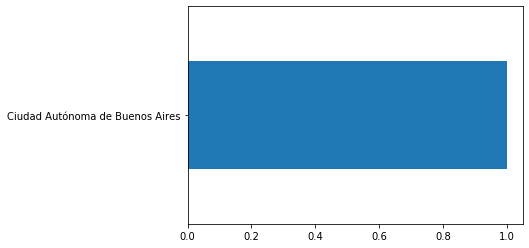

In [22]:
dataframe = dataframe[dataframe['donde_estas_trabajando']=='Ciudad Autónoma de Buenos Aires']
df = dataframe['donde_estas_trabajando'].value_counts(normalize=True, sort=True)

df.plot(kind='barh', logx=False);
charts['regions_percent'] = to_rechart(df)

#### 2.1.2. Roles (Posición, Open Source, Hobbie)

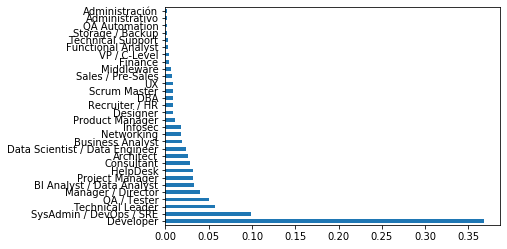

In [23]:
df = dataframe['trabajo_de'].value_counts(normalize=True, sort=True)

df[:30].plot.barh();
charts['roles_percent'] = to_rechart(df, 30)

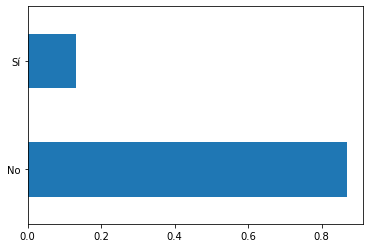

In [24]:
df = dataframe['contribuis_a_proyectos_open_source'].value_counts(normalize=True, sort=True)

df.plot.barh();
charts['opensource_percent'] = to_rechart(df)

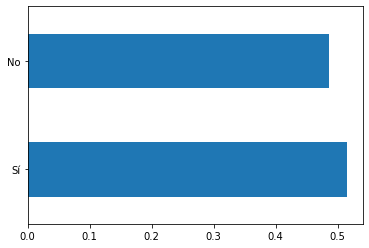

In [25]:
df = dataframe['programas_como_hobbie'].value_counts(normalize=True, sort=True)

df.plot.barh();
charts['hobbie_percent'] = to_rechart(df)

#### 2.1.3. Experiencia

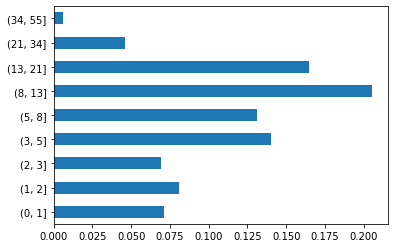

In [26]:
df = dataframe['anos_de_experiencia'].copy()
df = df.groupby(pd.cut(df.values, [0,1,2,3,5,8,13,21,34,55])).count()/len(df)

df.plot.barh()
charts['experience_years_percent'] = to_rechart(df.sort_index())

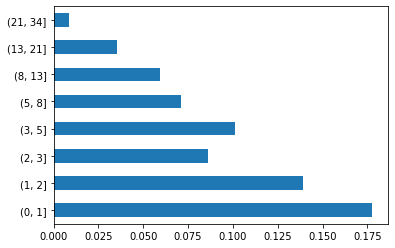

In [27]:
df = dataframe['anos_en_la_empresa_actual'].copy()
df = df.groupby(pd.cut(df.values, [0,1,2,3,5,8,13,21,34])).count()/len(df)

df.plot.barh()
charts['experience_years_in_company'] = to_rechart(df.sort_index())

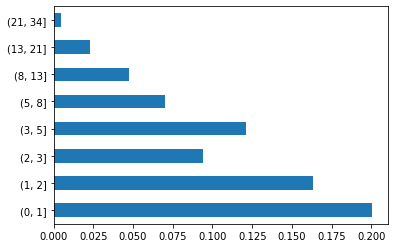

In [28]:
df = dataframe['anos_en_el_puesto_actual'].copy()
df = df.groupby(pd.cut(df.values, [0,1,2,3,5,8,13,21,34])).count()/len(df)

df.plot.barh()
charts['experience_years_in_position'] = to_rechart(df.sort_index())

#### 2.1.4. Educación

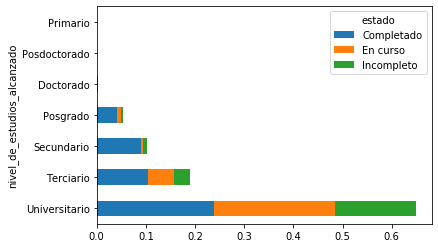

In [29]:
df = dataframe.groupby(['nivel_de_estudios_alcanzado', 'estado'])['nivel_de_estudios_alcanzado'].count().unstack('estado').fillna(0).sort_values(by=['Completado'], ascending=False) / len(dataframe)

df.plot(kind='barh', stacked=True, logx=False)
charts['education_stacked'] = to_rechart(df)

19.46

Index(['Ingeniería en Sistemas de Información', 'Ingeniería en Informática',
       'Analista de Sistemas', 'Licenciatura en Sistemas de Información',
       'Licenciatura en Ciencias de la Computación',
       'Licenciatura en Informática', 'Ingeniería Electrónica',
       'Tecnicatura en Programación', 'Licenciatura en Análisis de Sistemas',
       'Tecnicatura Superior en Programación',
       'Licenciatura en Administración de Empresas',
       'Tecnicatura en Informática', 'Diseño Gráfico',
       'Ingeniería en Computación', 'Ingeniería Industrial',
       'Tecnicatura Superior en Sistemas Informáticos',
       'Ingeniería en Telecomunicaciones', 'Analista Programador',
       'Tecnicatura Superior en Análisis de Sistemas', 'Telecomunicaciones',
       'Diseño Multimedial', 'Tecnicatura en Sistemas',
       'Tecnicatura Electrónica', 'Analista de Computación',
       'Ingeniería en Software', 'Tecnicatura en Computación'],
      dtype='object')

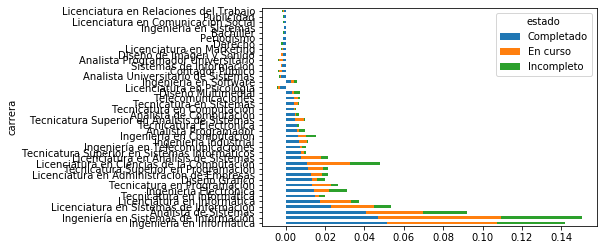

In [30]:
# Para el grado de completitud por carrera, tendremos en cuenta el tamaño de la muestra en cada caso, y "marcaremos como insuficientes" aquellas carreras que estén por debajo del 0.5% del total.
df = dataframe['carrera'].value_counts(normalize=True, sort=True).to_frame().query('carrera > 0.005')

# Un 0.5% es equivlente a aproximandamente 14 muestras.
display(len(dataframe['carrera'])*0.005)
chosen_careers = df.index
display(chosen_careers)

df = dataframe.query('carrera != "DELETEME"')['carrera'].value_counts(normalize=True, sort=True)
charts['careeres_percent'] = to_rechart(df, 40)

df = dataframe.query('carrera != "DELETEME"').groupby(['carrera', 'estado'])['carrera'].count().unstack('estado').fillna(0).sort_values(by=['Completado', 'En curso'], ascending=False)/len(dataframe)

df.loc[ df.eval('carrera not in @chosen_careers'), ['Completado', 'En curso', 'Incompleto'] ] *= -1

df[:40].plot(kind='barh', stacked=True, logx=False)
charts['careeres_stacked_percent'] = to_rechart(df[:40])

/Users/clrnd/.virtualenvs/datascience-mbHCaeZ9/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


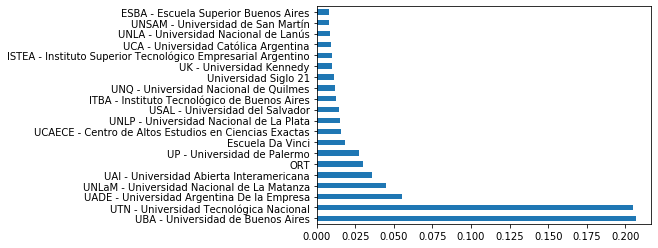

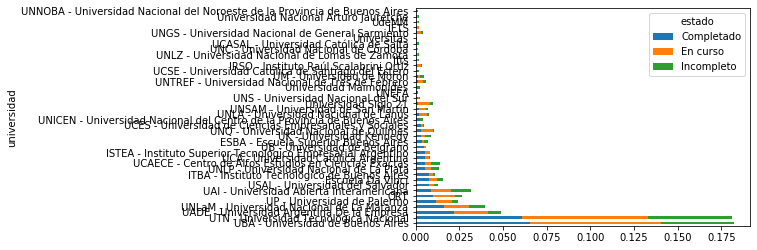

In [31]:
df = dataframe.query('universidad != "DELETEME"')['universidad'].value_counts(normalize=True, sort=True)

df[:20].plot(kind='barh')
charts['universities_percent'] = to_rechart(df, 40)

df = dataframe.query('universidad != "DELETEME"').groupby(['universidad', 'estado'])['universidad'].count().unstack('estado').fillna(0).sort_values(by=['Completado', 'En curso'], ascending=False)/len(dataframe)

df[:40].plot(kind='barh', stacked=True, logx=False)
charts['universities_stacked_percent'] = to_rechart(df, 40)

/Users/clrnd/.virtualenvs/datascience-mbHCaeZ9/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/clrnd/.virtualenvs/datascience-mbHCaeZ9/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


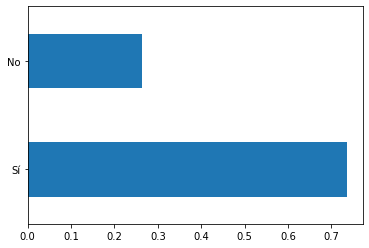

In [32]:
mask = dataframe['realizaste_cursos_de_especializacion'].str.contains('Sí')
dataframe.loc[ mask, 'hizo_curso'] = 'Sí'
dataframe.loc[ ~mask, 'hizo_curso'] = 'No'

df = dataframe['hizo_curso'].value_counts(normalize=True, sort=True)

df.plot(kind='barh')
charts['specialization_percent'] = to_rechart(df)

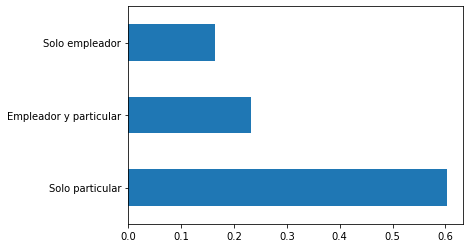

In [33]:
mask_empleador = dataframe['realizaste_cursos_de_especializacion'].str.contains('un empleador')
mask_particular = dataframe['realizaste_cursos_de_especializacion'].str.contains('de forma particular')

dataframe.loc[ mask_particular, 'quien_paga' ] = 'Solo particular'
dataframe.loc[ mask_empleador, 'quien_paga' ] = 'Solo empleador'
dataframe.loc[ mask_empleador & mask_particular, 'quien_paga' ] = 'Empleador y particular'

df = dataframe['quien_paga'].value_counts(normalize=True, sort=True)

df.plot(kind='barh')
charts['specialization_pays_percent'] = to_rechart(df)

#### 2.1.5. Demografía

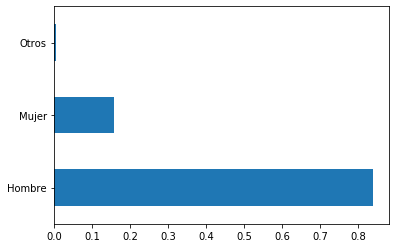

In [34]:
df = dataframe['me_identifico'].value_counts(normalize=True, sort=True)

df.plot(kind='barh')
charts['demographics_gender_percent'] = to_rechart(df)

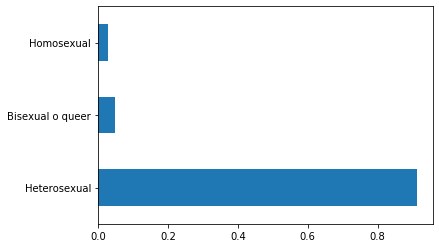

In [35]:
df = dataframe['orientacion_sexual'].value_counts(normalize=True, sort=True)

df[:3].plot(kind='barh')
charts['demographics_sexual_orientation_percent'] = to_rechart(df, 3)

### 2.2. Salarios

#### 2.2.1. Progresión Histórica

https://colab.research.google.com/drive/10IcHgqy-GahWjlKeWe4aPMpb1GljmC3l#scrollTo=Dqs6ictGuPF8

#### 2.2.2. Región

In [36]:
# Para este análisis, tendremos en cuenta la cantidad de muestras por región, y "marcaremos como insuficientes" aquellas regiones que estén por debajo del 0.5% del total.
# La razón por la cual hacemos esto, es que para algunas regiones se cuenta con muy pocos datos, y no sería correcto realizar un ranking comparando regiones sin tener en cuenta este gran detalle.
df = dataframe['donde_estas_trabajando'].value_counts(normalize=True, sort=True).to_frame().query('donde_estas_trabajando > 0.005')

# Un 0.5% es equivlente a aproximandamente 14 muestras.
display(len(dataframe['donde_estas_trabajando'])*0.005)
chosen_regions = df.index
display(chosen_regions)

19.46

Index(['Ciudad Autónoma de Buenos Aires'], dtype='object')

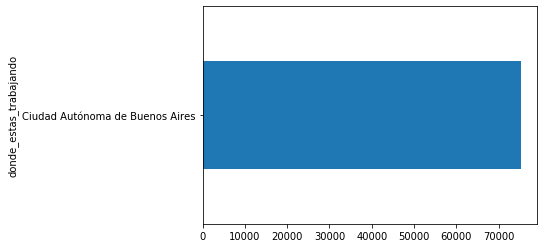

In [37]:
df = dataframe.copy()
# A pesar de marcarlas, no queremos omitirlas para no perjudicar a quienes quieran ver igualmente los resultados
# Para logralo las convertimos a valores negativos, y luego desde la UI del análisis las marcaremos como inválidas según el criterio mencionado
df.loc[ df.eval('donde_estas_trabajando not in @chosen_regions'), 'salario_mensual_bruto_en_tu_moneda_local'] *= -1
df = df.groupby(['donde_estas_trabajando']).median().unstack()['salario_mensual_bruto_en_tu_moneda_local'].sort_values(ascending=False)

df.plot(kind='barh')
charts['regions_salary_median'] = to_rechart(df)

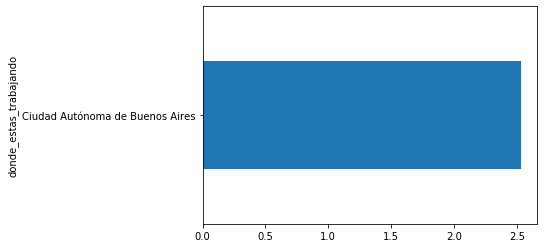

In [38]:
df = dataframe.copy()
df.loc[ df.eval('donde_estas_trabajando not in @chosen_regions'), 'que_tan_conforme_estas_con_tu_sueldo'] *= -1
df = df.groupby(['donde_estas_trabajando']).mean().unstack()['que_tan_conforme_estas_con_tu_sueldo'].sort_values(ascending=False)

df.plot(kind='barh')
charts['regions_salary_acquiescence'] = to_rechart(df)

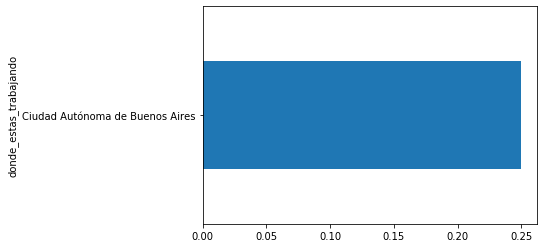

In [39]:
df = dataframe.copy()
df.loc[ df.eval('donde_estas_trabajando not in @chosen_regions'), 'de_que_fue_el_ajuste_total'] *= -1
df = df.groupby(['donde_estas_trabajando']).median().unstack()['de_que_fue_el_ajuste_total'].sort_values(ascending=False) / 100

df.plot(kind='barh')
charts['regions_salary_adjustment'] = to_rechart(df)

##### 2.2.2.1. Región (mínimos por seniority) - no incluídos en el reporte

In [40]:
df = dataframe.query('donde_estas_trabajando in @chosen_regions').groupby(['donde_estas_trabajando', 'seniority']).min().unstack()['salario_mensual_bruto_en_tu_moneda_local'].sort_values(by=['Senior'], ascending=False)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Ciudad Autónoma de Buenos Aires,10000,10000,6438


##### 2.2.2.2. Región (máximos por seniority) - no incluídos en el reporte

In [41]:
df = dataframe.query('donde_estas_trabajando in @chosen_regions').groupby(['donde_estas_trabajando', 'seniority']).max().unstack()['salario_mensual_bruto_en_tu_moneda_local'].sort_values(by=['Senior'],ascending=False)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Ciudad Autónoma de Buenos Aires,250000,304000,327000


#### 2.2.3. Puesto

##### 2.2.3.1. PROBANDO

In [109]:
df = dataframe.copy()

df['anos_de_experiencia_fibo'] = pd.cut(df['anos_de_experiencia'].values, [0,1,2,3,5,8,13,21,55])
# df = df.groupby(['anos_de_experiencia_fibo']).agg({
#       'salario_mensual_bruto_en_tu_moneda_local': 'median',
#       'salario_mensual_bruto_en_tu_moneda_local': 'min',
#       'salario_mensual_bruto_en_tu_moneda_local': 'max',
#     }).fillna(0).reset_index()
#df.columns = df.columns.droplevel(0)
display(df.columns)
df[['me_identifico',
    'tengo',
    'estoy_trabajando_en',
    'donde_estas_trabajando',
    'anos_de_experiencia',
    'salario_mensual_bruto_en_tu_moneda_local',
    'cuales_consideras_que_son_las_mejores_empresas_de_it_para_trabajar_en_este_momentoen_tu_ciudad']]
# g = sns.FacetGrid(df, col='anos_de_experiencia_fibo', col_wrap=4)
# g = g.map(sns.kdeplot, 'salario_mensual_bruto_en_tu_moneda_local')

Index(['timestamp', 'me_identifico', 'tengo', 'estoy_trabajando_en',
       'donde_estas_trabajando', 'anos_de_experiencia',
       'anos_en_la_empresa_actual', 'anos_en_el_puesto_actual',
       'gente_a_cargo', 'nivel_de_estudios_alcanzado', 'estado', 'carrera',
       'universidad', 'realizaste_cursos_de_especializacion',
       'contribuis_a_proyectos_open_source', 'programas_como_hobbie',
       'trabajo_de', 'plataformas', 'lenguajes_de_programacion',
       'frameworksherramientas_y_librerias', 'bases_de_datos', 'qa_testing',
       'ides', 'que_so_usas_en_tu_laptoppc_para_trabajar', 'y_en_tu_celular',
       'tenes_guardias', 'cuanto_cobras_por_guardia', 'porcentajebruto_o_neto',
       'tipo_de_contrato', 'salario_mensual_bruto_en_tu_moneda_local',
       'salario_mensual_neto_en_tu_moneda_local',
       'que_tan_conforme_estas_con_tu_sueldo',
       'como_crees_que_esta_tu_sueldo_con_respecto_al_ultimo_semestre',
       'recibis_algun_tipo_de_bono', 'a_que_esta_atado_el_bono'

,me_identifico,tengo,estoy_trabajando_en,donde_estas_trabajando,anos_de_experiencia,salario_mensual_bruto_en_tu_moneda_local,cuales_consideras_que_son_las_mejores_empresas_de_it_para_trabajar_en_este_momentoen_tu_ciudad
1,Hombre,30,Argentina,Ciudad Autónoma de Buenos Aires,3,48000,mercadolibre
2,Mujer,40,Argentina,Ciudad Autónoma de Buenos Aires,15,42000,NaN
3,Mujer,36,Argentina,Ciudad Autónoma de Buenos Aires,10,75000,NaN
4,Hombre,29,Argentina,Ciudad Autónoma de Buenos Aires,10,40000,NaN
5,Hombre,27,Argentina,Ciudad Autónoma de Buenos Aires,4,37518,NaN
...,...,...,...,...,...,...,...
5971,Mujer,38,Argentina,Ciudad Autónoma de Buenos Aires,15,310000,NaN
5974,Hombre,45,Argentina,Ciudad Autónoma de Buenos Aires,12,200000,"Hewlett Packard, IBM, Google"
5976,Hombre,35,Argentina,Ciudad Autónoma de Buenos Aires,12,195000,NaN
5980,Hombre,40,Argentina,Ciudad Autónoma de Buenos Aires,16,34000,NaN


##### 2.2.3.1. Seniority

19.46

Index(['Developer', 'SysAdmin / DevOps / SRE', 'Technical Leader',
       'QA / Tester', 'Manager / Director', 'BI Analyst / Data Analyst',
       'Project Manager', 'HelpDesk', 'Consultant', 'Architect',
       'Data Scientist / Data Engineer', 'Business Analyst', 'Networking',
       'Infosec', 'Product Manager', 'Designer', 'Recruiter / HR', 'DBA',
       'Scrum Master', 'UX', 'Sales / Pre-Sales', 'Middleware'],
      dtype='object')

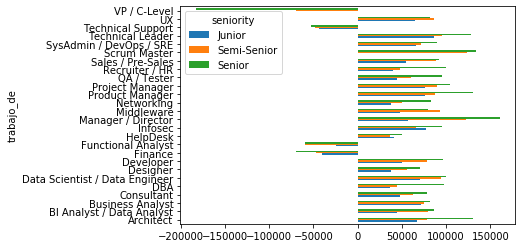

In [45]:
# Para este análisis, tendremos en cuenta la cantidad de muestras por puesto de trabajo, y "marcaremos como insuficientes" aquellos que estén por debajo del 0.5% del total.
df = dataframe['trabajo_de'].value_counts(normalize=True, sort=True).to_frame().query('trabajo_de > 0.005')

# Un 0.5% es equivlente a aproximandamente 14 muestras.
display(len(dataframe['trabajo_de'])*0.005)
chosen_roles = df.index
display(chosen_roles)


df = dataframe['trabajo_de'].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

df = dataframe.query('trabajo_de in @top_roles').groupby(['trabajo_de', 'seniority']).median().unstack('seniority')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)#.sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)
df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Junior', 'Semi-Senior', 'Senior']] *= -1

df.plot(kind='barh')
charts['roles_seniority_salary_median'] = to_rechart(df[:30])

##### 2.2.3.1. Industria

19.46

Index(['Developer', 'SysAdmin / DevOps / SRE', 'Technical Leader',
       'QA / Tester', 'Manager / Director', 'BI Analyst / Data Analyst',
       'Project Manager', 'HelpDesk', 'Consultant', 'Architect',
       'Data Scientist / Data Engineer', 'Business Analyst', 'Networking',
       'Infosec', 'Product Manager', 'Designer', 'Recruiter / HR', 'DBA',
       'Scrum Master', 'UX', 'Sales / Pre-Sales', 'Middleware'],
      dtype='object')

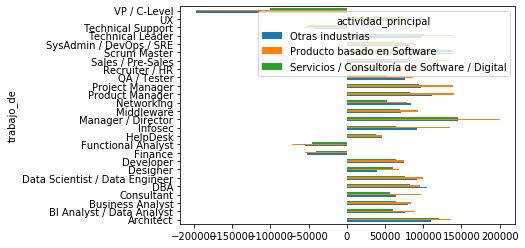

In [46]:
# Para este análisis, tendremos en cuenta la cantidad de muestras por puesto de trabajo, y "marcaremos como insuficientes" aquellos que estén por debajo del 0.5% del total.
df = dataframe['trabajo_de'].value_counts(normalize=True, sort=True).to_frame().query('trabajo_de > 0.005')

# Un 0.5% es equivlente a aproximandamente 14 muestras.
display(len(dataframe['trabajo_de'])*0.005)
chosen_roles = df.index
display(chosen_roles)


df = dataframe['trabajo_de'].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

df = dataframe.query('trabajo_de in @top_roles').groupby(['trabajo_de', 'actividad_principal']).median().unstack('actividad_principal')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)#.sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)
#display(df)
df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Otras industrias', 'Producto basado en Software', 'Servicios / Consultoría de Software / Digital']] *= -1

df.plot(kind='barh')
charts['roles_actividad_principal_salary_median'] = to_rechart(df[:30])

##### 2.2.3.3. Seniority e Industria

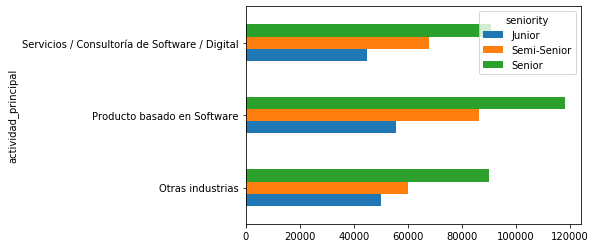

In [47]:
df = dataframe.groupby(['actividad_principal', 'seniority']).median().unstack('seniority')['salario_mensual_bruto_en_tu_moneda_local']#.sort_values(by=[''],ascending=False)

df.plot.barh()
charts['actividad_principal_seniority_salary_median'] = to_rechart(df)

##### 2.2.3.2. Open source / hobbie

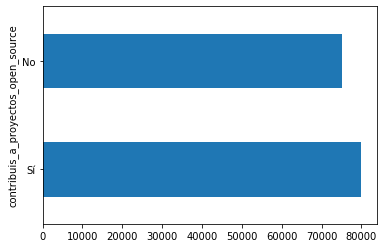

In [48]:
df = dataframe.groupby(['contribuis_a_proyectos_open_source']).median().unstack()['salario_mensual_bruto_en_tu_moneda_local'].sort_values(ascending=False)

df.plot(kind='barh')
charts['opensource_salary_median'] = to_rechart(df)

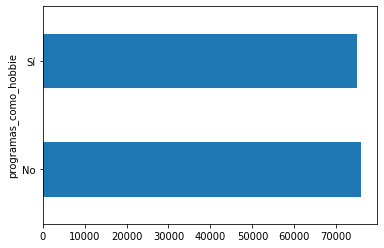

In [49]:
df = dataframe.groupby(['programas_como_hobbie']).median().unstack()['salario_mensual_bruto_en_tu_moneda_local'].sort_values(ascending=False)

df.plot.barh()
charts['hobbie_salary_median'] = to_rechart(df)

#### 2.2.4. Carrera

In [50]:
df = dataframe.groupby(['carrera', 'estado'])['carrera'].count().unstack('estado').fillna(0).sort_values(by=['Completado', 'En curso'], ascending=False)/len(dataframe)
#display(df[:30])
top_careers = df[:30].index

# Para este análisis, tendremos en cuenta la cantidad de muestras por carrera, y "marcaremos como insuficientes" aquellas que estén por debajo del 0.5% del total.
# La razón por la cual hacemos esto, es que para algunas regiones se cuenta con muy pocos datos, y no sería correcto realizar un ranking comparando carreras sin tener en cuenta este gran detalle.
df = df[:30]['Completado'].to_frame().query('Completado > 0.005')
display(df)
chosen_careers = df.index

,Completado
carrera,
Ingeniería en Informática,0.051644
Ingeniería en Sistemas de Información,0.046763
Analista de Sistemas,0.040853
Licenciatura en Sistemas de Información,0.022867
Licenciatura en Informática,0.017472
Tecnicatura en Informática,0.014902
Ingeniería Electrónica,0.014132
Tecnicatura en Programación,0.013361
Diseño Gráfico,0.013361


##### 2.2.4.1. Según Seniority

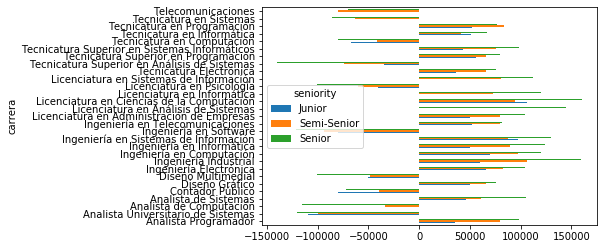

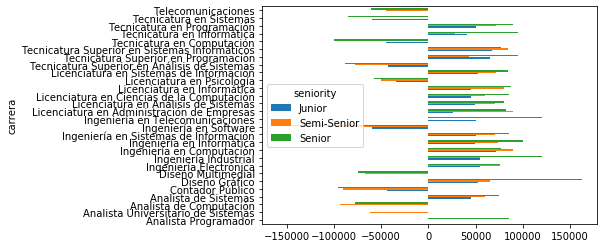

In [51]:
df = dataframe.query('estado == "Completado"').copy()
df = invert_non_reresentative_values(df, 'carrera', chosen_careers)
df = filter_valid_top_values(df, 'carrera', top_careers)
df = get_two_dimensional_median_with_ouliers_filtered(df, ['carrera', 'seniority'], 'salario_mensual_bruto_en_tu_moneda_local')

df[:30].plot(kind='barh')
charts['carrera_seniority_salary_median'] = to_rechart(df[:30])


df = dataframe.query('estado == "En curso"').copy()
df = invert_non_reresentative_values(df, 'carrera', chosen_careers)
df = filter_valid_top_values(df, 'carrera', top_careers)
df = get_two_dimensional_median_with_ouliers_filtered(df, ['carrera', 'seniority'], 'salario_mensual_bruto_en_tu_moneda_local')

df[:30].plot(kind='barh')
charts['carrera_seniority_salary_median_encurso'] = to_rechart(df[:30])

In [52]:
# Cuántos Ingenieros Industriales hay en el resultado obtenido, ya que sobresale del resto
df = dataframe.query('carrera in ["Ingeniería Industrial"] & estado == "Completado"')[ ['seniority', 'trabajo_de', 'salario_mensual_bruto_en_tu_moneda_local'] ]\
  .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

display('Un {:.2f}%'.format(len(df)/len(dataframe) * 100))
display(df)

'Un 0.67%'

,seniority,trabajo_de,salario_mensual_bruto_en_tu_moneda_local
5953,Senior,VP / C-Level,250000
3875,Senior,Manager / Director,241700
3894,Semi-Senior,Manager / Director,240000
590,Senior,Consultant,200000
562,Senior,Consultant,200000
5966,Senior,VP / C-Level,186000
4370,Senior,Project Manager,160000
133,Senior,Architect,159000
4344,Senior,Project Manager,150000
4194,Senior,Product Manager,135000


##### 2.2.4.2. Según Estado de la Carrera

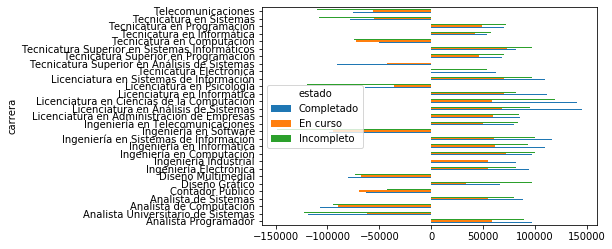

In [53]:
df = dataframe.copy()
df = invert_non_reresentative_values(df, 'carrera', chosen_careers)
df = filter_valid_top_values(df, 'carrera', top_careers)
df = get_two_dimensional_median_with_ouliers_filtered(df, ['carrera', 'estado'], 'salario_mensual_bruto_en_tu_moneda_local')

df[:30].plot(kind='barh')
charts['carrera_estado_salary_median'] = to_rechart(df[:30])

##### 2.2.4.3. Según Nivel de Estudios Alcanzado

19.46

Index(['Universitario', 'Terciario', 'Secundario', 'Posgrado'], dtype='object')

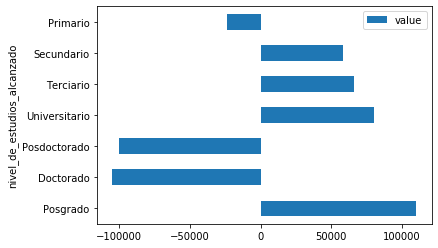

In [54]:
# Para este análisis, tendremos en cuenta la cantidad de muestras por nivel de estudios alcanzado, y "marcaremos como insuficientes" aquellaos que estén por debajo del 0.5% del total.
df = dataframe['nivel_de_estudios_alcanzado'].value_counts(normalize=True, sort=True).to_frame().query('nivel_de_estudios_alcanzado > 0.005')

# Un 0.5% es equivlente a aproximandamente 14 muestras.
display(len(dataframe['nivel_de_estudios_alcanzado'])*0.005)
chosen_levels = df.index
display(chosen_levels)

df = dataframe.groupby(['nivel_de_estudios_alcanzado']).median().unstack()['salario_mensual_bruto_en_tu_moneda_local'].sort_values(ascending=False).to_frame('value')
df.loc[ df.eval('nivel_de_estudios_alcanzado not in @chosen_levels'), 'value' ] *= -1

df.plot(kind='barh')
charts['nivel_estudios_salary_median'] = to_rechart(df)

##### 2.2.4.4. Según hicieron o no Cursos de Especialización

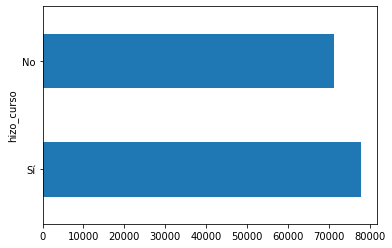

In [55]:
df = dataframe.groupby(['hizo_curso']).median().unstack()['salario_mensual_bruto_en_tu_moneda_local'].sort_values(ascending=False)

df.plot(kind='barh')
charts['hizo_curso_salary_median'] = to_rechart(df)

#### 2.2.5. Tecnología

##### 2.2.5.1. Según Plataformas

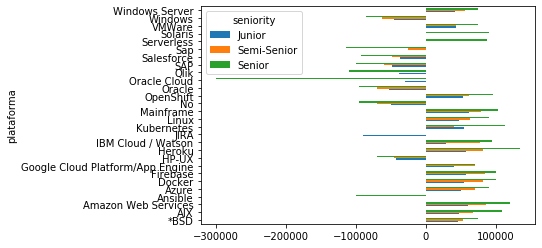

In [56]:
# Para este análisis, tendremos en cuenta la cantidad de muestras por plataforma, y "marcaremos como insuficientes" aquellas que estén por debajo del 0.5% del total.
df = dataframe['plataformas'].str.extractall(r"(?P<count>[^,]+),? ?")['count'].value_counts(normalize=True, sort=True)
top_platforms = df[:30].index

chosen_platforms = df.to_frame().query('count > 0.005').index

df = dataframe.copy()
df = df['plataformas'].str.split(',').apply(pd.Series)\
  .merge(df, right_index=True, left_index=True)\
  .drop(['plataformas'], axis = 1)\
  .melt(id_vars=['seniority', 'salario_mensual_bruto_en_tu_moneda_local'], value_name='plataforma')\
  .drop(['variable'], axis = 1)\
  .dropna()\
  .query('plataforma in @top_platforms')\
  .groupby(['plataforma', 'seniority']).median().unstack('seniority')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)

df.loc[ df.eval('plataforma not in @chosen_platforms'), ['Junior', 'Semi-Senior', 'Senior'] ] *= -1

df[:30].plot(kind='barh')
charts['plataformas_seniority_salary_median'] = to_rechart(df[:30])

##### 2.2.5.2. Según Lenguajes de Programación

seniority,Junior,Semi-Senior,Senior
lenguaje_de_programacion,,,
.NET,50000.0,72000.0,96000.0
ABAP,-46650.0,-85000.0,-100000.0
ActionScript,-72800.0,-48000.0,-75000.0
Assembler,-45000.0,-142500.0,-83000.0
Bash/Shell,62500.0,74418.0,106000.0
C,58000.0,82750.0,100000.0
C#,46000.0,67500.0,85250.0
C++,40335.0,46000.0,110000.0
COBOL,-47500.0,-90000.0,-114500.0


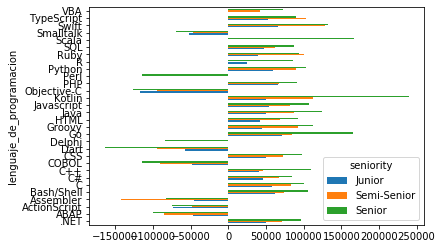

In [57]:
# Para este análisis, tendremos en cuenta la cantidad de muestras por lenguaje, y "marcaremos como insuficientes" aquellos que estén por debajo del 0.5% del total.
df = dataframe['lenguajes_de_programacion'].str.extractall(r"(?P<count>[^,]+),? ?")['count'].value_counts(normalize=True, sort=True)
top_languages = df[:30].index

chosen_languages = df.to_frame().query('count > 0.005').index

df = dataframe.copy()
df = df['lenguajes_de_programacion'].str.split(',').apply(pd.Series)\
  .merge(df, right_index=True, left_index=True)\
  .drop(['lenguajes_de_programacion'], axis = 1)\
  .melt(id_vars=['seniority', 'salario_mensual_bruto_en_tu_moneda_local'], value_name='lenguaje_de_programacion')\
  .drop(['variable'], axis = 1)\
  .dropna()\
  .query('lenguaje_de_programacion in @top_languages')\
  .groupby(['lenguaje_de_programacion', 'seniority']).median().unstack('seniority')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)

df.loc[ df.eval('lenguaje_de_programacion not in @chosen_languages'), ['Junior', 'Semi-Senior', 'Senior'] ] *= -1

display(df)
df.plot(kind='barh')
charts['lenguajes_de_programacion_seniority_salary_median'] = to_rechart(df[:30])

##### 2.2.6. Otras compensaciones

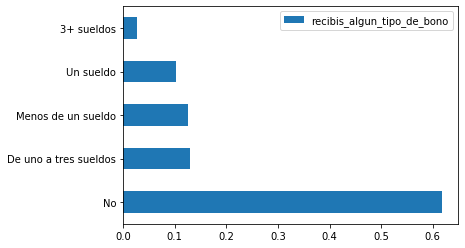

In [58]:
df = dataframe['recibis_algun_tipo_de_bono'].value_counts(normalize=True, sort=True).to_frame()

df.plot(kind='barh')
charts['bonos_percent'] = to_rechart(df)

#### 2.2.6. Tipo de contrato

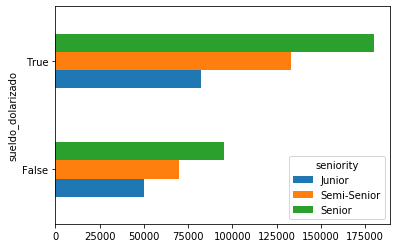

In [59]:
df = dataframe.groupby(['sueldo_dolarizado', 'seniority']).median().unstack('seniority')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)#.sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)
df.plot(kind='barh')
charts['sueldo_dolarizado_salary_median'] = to_rechart(df)

### 2.3. Género

#### 2.3.1. Progresión Histórica

#### 2.3.2. Preparación

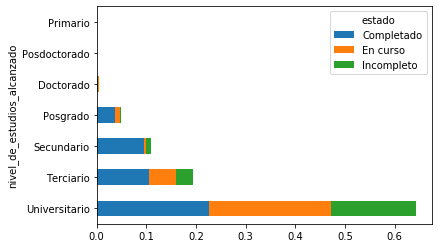

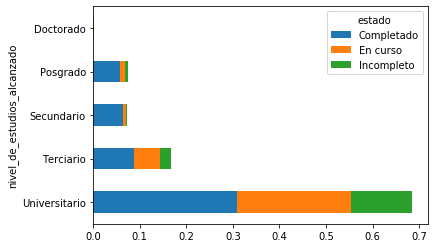

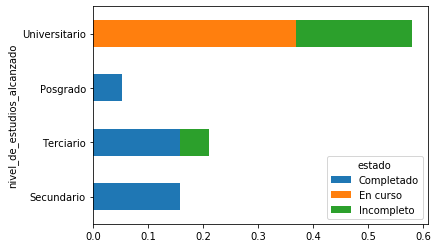

In [60]:
df = dataframe.query('me_identifico == "Hombre"')
df = df.groupby(['nivel_de_estudios_alcanzado', 'estado'])['nivel_de_estudios_alcanzado'].count().unstack('estado').fillna(0).sort_values(by=['Completado'], ascending=False)/len(df)
df.plot(kind='barh', stacked=True, logx=False)
charts['education_hombre_stacked'] = to_rechart(df)

df = dataframe.query('me_identifico == "Mujer"')
df = df.groupby(['nivel_de_estudios_alcanzado', 'estado'])['nivel_de_estudios_alcanzado'].count().unstack('estado').fillna(0).sort_values(by=['Completado'], ascending=False)/len(df)
df.plot(kind='barh', stacked=True, logx=False)
charts['education_mujer_stacked'] = to_rechart(df)

df = dataframe.query('me_identifico == "Otros"')
df = df.groupby(['nivel_de_estudios_alcanzado', 'estado'])['nivel_de_estudios_alcanzado'].count().unstack('estado').fillna(0).sort_values(by=['Completado'], ascending=False)/len(df)
df.plot(kind='barh', stacked=True, logx=False)
charts['education_otros_stacked'] = to_rechart(df)

#### 2.3.3. Salarios

In [61]:
# df = dataframe['trabajo_de'].value_counts(normalize=True, sort=True)
# top_roles = df[:26].index

# df = dataframe.query('(trabajo_de in @top_roles) & (seniority == "Junior")')
# df = df.groupby(['trabajo_de', 'me_identifico']).median().unstack('me_identifico')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)
# df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Hombre', 'Mujer', 'Otros']] *= -1
# charts['roles_seniority_salary_junior_median'] = to_rechart(df, 30)
# df.plot(kind='barh')

# df = dataframe.query('(trabajo_de in @top_roles) & (seniority == "Semi-Senior")')
# df = df.groupby(['trabajo_de', 'me_identifico']).median().unstack('me_identifico')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)
# df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Hombre', 'Mujer', 'Otros']] *= -1
# charts['roles_seniority_salary_semisenior_median'] = to_rechart(df, 30)
# df.plot(kind='barh')

# df = dataframe.query('(trabajo_de in @top_roles) & (seniority == "Senior")')
# df = df.groupby(['trabajo_de', 'me_identifico']).median().unstack('me_identifico')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)
# df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Hombre', 'Mujer', 'Otros']] *= -1
# charts['roles_seniority_salary_senior_median'] = to_rechart(df, 30)
# df.plot(kind='barh')

In [62]:
df = dataframe['trabajo_de'].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

top_salary_roles = dataframe.query('trabajo_de in @top_roles').groupby(['trabajo_de']).median()['salario_mensual_bruto_en_tu_moneda_local'].fillna(0).sort_values(0, ascending=False).index.tolist()
top_salary_roles_mujer = dataframe.query('trabajo_de in @top_roles & me_identifico == "Mujer"').groupby(['trabajo_de']).median()['salario_mensual_bruto_en_tu_moneda_local'].fillna(0).sort_values(0, ascending=False).index.tolist()

# listamos los roles entre los mejores pagos de los cuales no hay mujeres
display([rol for rol in top_salary_roles if rol not in top_salary_roles_mujer])

['DBA', 'Middleware', 'Technical Support']

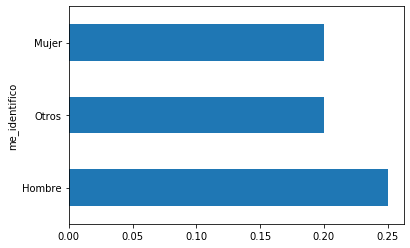

In [63]:
df = dataframe.groupby(['me_identifico']).median().unstack()['de_que_fue_el_ajuste_total'].sort_values(ascending=False) / 100

df.plot(kind='barh')
charts['gender_salary_adjustment'] = to_rechart(df)

#### 2.3.4. Experiencia

me_identifico,Hombre,Mujer,Otros
actividad_principal,,,
Otras industrias,0.828221,0.168273,0.003506
Producto basado en Software,0.853713,0.139535,0.006752
Servicios / Consultoría de Software / Digital,0.831453,0.164316,0.004231


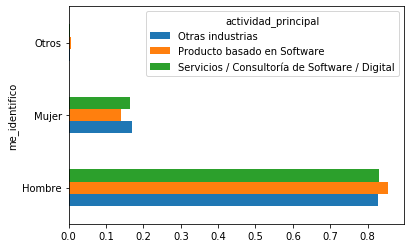

In [64]:
df = dataframe
df = df.groupby(['actividad_principal', 'me_identifico']).agg({'me_identifico': 'count'}).groupby(level=0).apply(lambda x: x / float(x.sum())).unstack('me_identifico')
df.columns = df.columns.droplevel(0)
display(df)
df.T.plot(kind='barh')
charts['actividad_principal_gender_percent'] = to_rechart(df)

me_identifico,Hombre,Mujer,Otros
anos_de_experiencia_fibo,,,
"(0, 1]",0.787004,0.198556,0.014440
"(1, 2]",0.771429,0.228571,0.000000
"(2, 3]",0.836431,0.156134,0.007435
"(3, 5]",0.849817,0.148352,0.001832
"(5, 8]",0.839216,0.150980,0.009804
"(8, 13]",0.855000,0.142500,0.002500
"(13, 21]",0.903125,0.093750,0.003125
"(21, 55]",0.857843,0.137255,0.004902


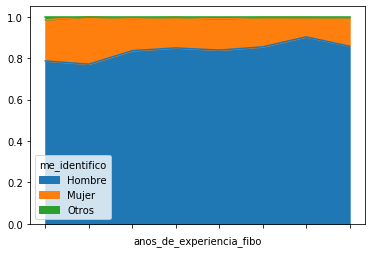

In [65]:
df = dataframe.copy()
df['anos_de_experiencia_fibo'] = pd.cut(df['anos_de_experiencia'].values, [0,1,2,3,5,8,13,21,55])
df = df.groupby(['anos_de_experiencia_fibo', 'me_identifico']).agg({'me_identifico': 'count'}).groupby(level=0).apply(lambda x: x / float(x.sum())).unstack('me_identifico').fillna(0)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind='area')
charts['experience_gender_percent'] = to_rechart(df)

me_identifico,Hombre,Mujer,Otros
anos_de_experiencia_fibo,,,
"(0, 1]",45000.0,42000.0,47500.0
"(1, 2]",55200.0,49795.0,0.0
"(2, 3]",70000.0,58500.0,54875.0
"(3, 5]",76000.0,69000.0,134000.0
"(5, 8]",90000.0,90000.0,97000.0
"(8, 13]",97000.0,85074.0,189500.0
"(13, 21]",110000.0,81500.0,190000.0
"(21, 55]",107000.0,83500.0,40000.0


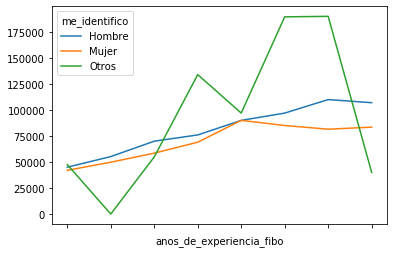

In [66]:
df = dataframe.copy()
df['anos_de_experiencia_fibo'] = pd.cut(df['anos_de_experiencia'].values, [0,1,2,3,5,8,13,21,55])
df = df.groupby(['anos_de_experiencia_fibo', 'me_identifico']).agg({'salario_mensual_bruto_en_tu_moneda_local': 'median'}).unstack('me_identifico').fillna(0)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind='line')
charts['experience_gender_salary_median'] = to_rechart(df)

me_identifico,Hombre,Mujer,Otros
anos_de_experiencia_fibo,,,
"(0, 1]",2.444954,2.436364,2.5
"(1, 2]",2.473251,2.597222,0.0
"(2, 3]",2.564444,2.380952,3.0
"(3, 5]",2.556034,2.469136,3.0
"(5, 8]",2.546729,2.532468,2.8
"(8, 13]",2.596491,2.587719,3.0
"(13, 21]",2.557093,2.466667,2.5
"(21, 55]",2.520000,2.035714,3.0


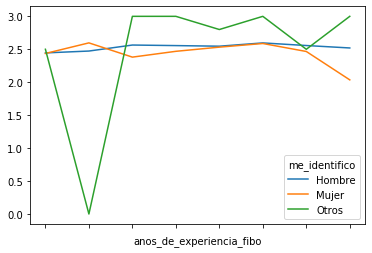

In [67]:
df = dataframe.copy()
df['anos_de_experiencia_fibo'] = pd.cut(df['anos_de_experiencia'].values, [0,1,2,3,5,8,13,21,55])
df = df.groupby(['anos_de_experiencia_fibo', 'me_identifico']).agg({'que_tan_conforme_estas_con_tu_sueldo': 'mean'}).unstack('me_identifico').fillna(0)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind='line')
charts['experience_gender_conformidad_mean'] = to_rechart(df)

#### 2.3.5. Discapacidad

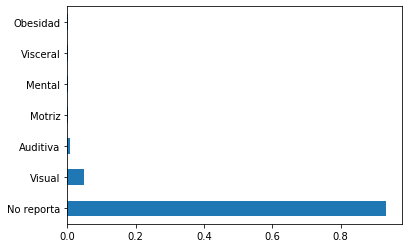

In [68]:
df = dataframe['tenes_algun_tipo_de_discapacidad'].fillna('No reporta').value_counts(normalize=False, sort=True)/len(dataframe)
#display(df)

#df = dataframe['tenes_algun_tipo_de_discapacidad'].value_counts(normalize=True, sort=True)#.to_frame()

df[:7].plot(kind='barh')
charts['discapacidad_percent'] = to_rechart(df, 7)

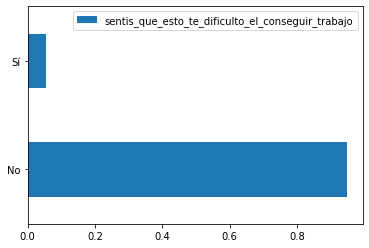

In [69]:
# Quienes respondieron Sí o No, son quienes contestaron sobre discapacidad.  El resto es None
df = dataframe['sentis_que_esto_te_dificulto_el_conseguir_trabajo'].value_counts(normalize=True, sort=True).to_frame()

df.plot(kind='barh')
charts['discapacidad_dificultad_percent'] = to_rechart(df)

### 2.4. Tecnología

#### 2.4.1. Plataformas más populares

'reduced in 0.032353'

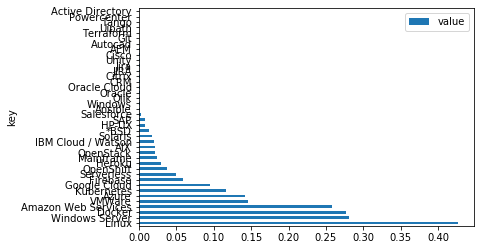

In [70]:
df = dataframe['plataformas'].str.extractall(r"(?P<value>[^,]+),? ?")['value'].value_counts(normalize=False, sort=True).to_frame().rename_axis('key')
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(df, 'key', {
    'Google Cloud Platform/App Engine': 'Google Cloud',
    'Sap': 'SAP',
    'crm': 'CRM',
    '^(nada|no|ningun[ao]|otros?|0|-)$': 'DELETEME',
})

# Reagrupamos valores, sumándolos, luegode haber normalizado
df = df.query('key != "DELETEME"').groupby('key').sum()['value'].sort_values(ascending=False).to_frame() / len(dataframe)

df[:40].plot.barh()
charts['plataformas'] = to_rechart(df[:40])

#### 2.4.2. Lenguajes de Programación más populares

'reduced in 0.061224'

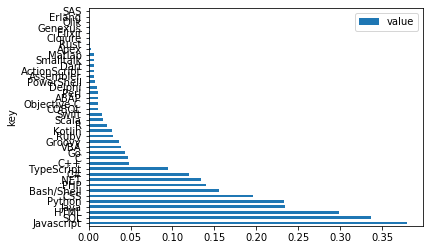

In [71]:
df = dataframe['lenguajes_de_programacion'].str.extractall(r"(?P<value>[^,]+),? ?")['value'].value_counts(normalize=False, sort=True).to_frame().rename_axis('key')
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(df, 'key', {
    'powershell': 'PowerShell',
    'cobol': 'COBOL',
    '^(nada|no|ningun[ao]|otros?|-)$': 'DELETEME',
})

# Reagrupamos valores, sumándolos, luegode haber normalizado
df = df.query('key != "DELETEME"').groupby('key').sum()['value'].sort_values(ascending=False).to_frame() / len(dataframe)

df[:40].plot.barh()
charts['lenguajes_de_programacion'] = to_rechart(df[:40])

#### 2.4.3. Frameworks, Herramientas y Librerías más populares

'reduced in 0.048387'

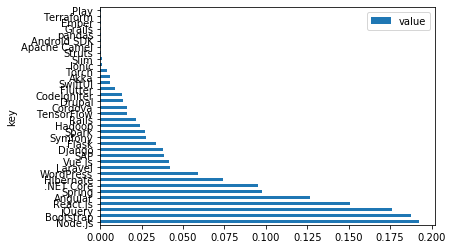

In [72]:
df = dataframe['frameworksherramientas_y_librerias'].str.extractall(r"(?P<value>[^,]+),? ?")['value'].value_counts(normalize=False, sort=True).to_frame().rename_axis('key')
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(df, 'key', {
    '.*(node).*$': 'Node.js',
    '.*Angular.*$': 'Angular',
    '.*React.*$': 'React.js',
    '.*Vue.*$': 'Vue.js',
    '.*jquery.*$': 'jQuery',
    '.*laravel.*$': 'Laravel',
    '.*codeigniter.*$': 'CodeIgniter',
    '.*struts.*$': 'Struts',
    '^(nada|no|ningun[ao]|otros?|0|-)$': 'DELETEME',
})

# Reagrupamos valores, sumándolos, luegode haber normalizado
df = df.query('key != "DELETEME"').groupby('key').sum()['value'].sort_values(ascending=False).to_frame() / len(dataframe)

df[:36].plot.barh()
charts['frameworksherramientas_y_librerias'] = to_rechart(df[:36])

#### 2.4.4. Bases de Datos más populares

'reduced in 0.038835'

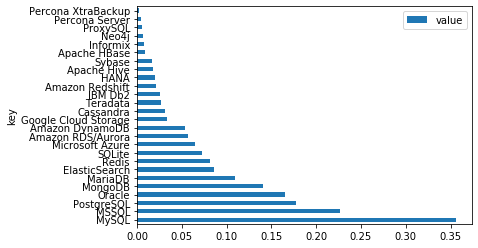

In [73]:
df = dataframe['bases_de_datos'].str.extractall(r"(?P<value>[^,]+),? ?")['value'].value_counts(normalize=False, sort=True).to_frame().rename_axis('key')
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(df, 'key', {
    '.*(sybase).*$': 'Sybase',
    'Microsoft Azure \(Tables': 'Microsoft Azure',
    '^(SQL|CosmosDB|etc\)|otros?|0|-)$': 'DELETEME',
})

# Reagrupamos valores, sumándolos, luegode haber normalizado
df = df.query('key != "DELETEME"').groupby('key').sum()['value'].sort_values(ascending=False).to_frame() / len(dataframe)

df[:26].plot.barh()
charts['bases_de_datos'] = to_rechart(df[:26])

#### 2.4.5. Herramientas de QA / Testing más populares

'reduced in 0.128571'

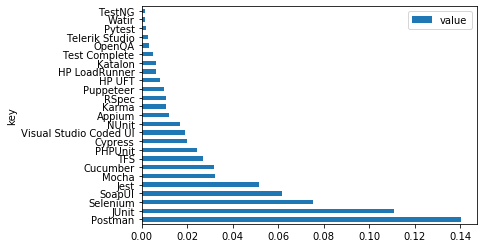

In [74]:
df = dataframe['qa_testing'].str.extractall(r"(?P<value>[^,]+),? ?")['value'].value_counts(normalize=False, sort=True).to_frame().rename_axis('key')
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(df, 'key', {
    '.*(ningun[oa]|no|nada|otros?|0).*$': 'DELETEME',
    '.*(junit).*$': 'JUnit',
    '.*(jest).*$': 'Jest',
})

# Reagrupamos valores, sumándolos, luegode haber normalizado
df = df.query('key != "DELETEME"').groupby('key').sum()['value'].sort_values(ascending=False).to_frame() / len(dataframe)

df[:25].plot.barh()
charts['qa_testing'] = to_rechart(df[:25])

#### 2.4.6. IDEs más populares

'reduced in 0.140000'

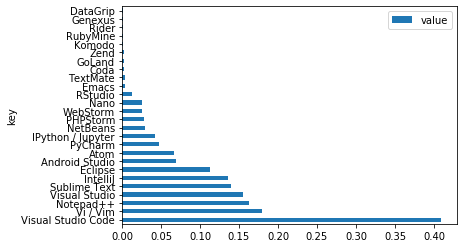

In [75]:
df = dataframe['ides'].str.extractall(r"(?P<value>[^,]+),? ?")['value'].value_counts(normalize=False, sort=True).to_frame().rename_axis('key')
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(df, 'key', {
    '^.*(Visual Studio|VS).*$': 'Visual Studio',
    '^.*(Visual Studio Code|VS ?Code|Code).*$': 'Visual Studio Code',
    '.*(Sublime)( Text)?.*$': 'Sublime Text',
    '.*(webstorm).*$': 'WebStorm',
    '^(vi|vim)$': 'Vi / Vim',
    '^(jdeveloper)$': 'JDeveloper',
    '^(goland)$': 'GoLand',
    '^(neovim)$': 'NeoVim',
    'IBM integración toolkit': 'IBM Integration Bus',
    '^(no( uso.*| util.*)?|none|ningun[ao]|0|No s[eé]|nada|-|\.)$': 'DELETEME',
})

# Reagrupamos valores, sumándolos, luegode haber normalizado
df = df.query('key != "DELETEME"').groupby('key').sum()['value'].sort_values(ascending=False).to_frame() / len(dataframe)

df[:26].plot.barh()
charts['ides'] = to_rechart(df[:26])

### 2.5. Trabajo

#### 2.5.1. Tipos de contrato

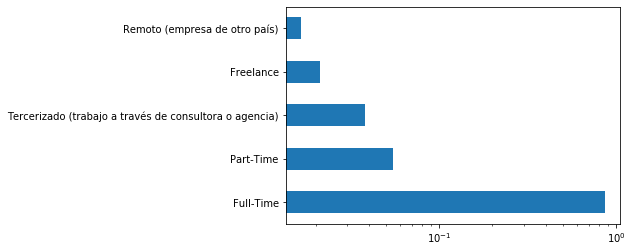

In [76]:
df = dataframe['tipo_de_contrato'].value_counts(normalize=True, sort=True)

df.plot(kind='barh', logx=True);
charts['tipo_de_contrato_percent'] = to_rechart(df)

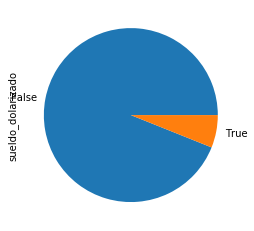

In [77]:
df = dataframe['sueldo_dolarizado'].value_counts(normalize=True, sort=True)
df.plot.pie();
charts['sueldo_dolarizado_percent'] = to_rechart(df)

#### 2.5.2. Compensación

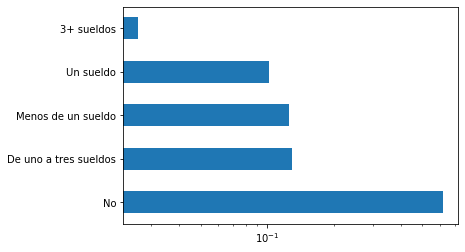

In [78]:
df = dataframe['recibis_algun_tipo_de_bono'].value_counts(normalize=True, sort=True)

df.plot(kind='barh', logx=True);
charts['recibis_algun_tipo_de_bono'] = to_rechart(df)

'reduced in 0.283582'

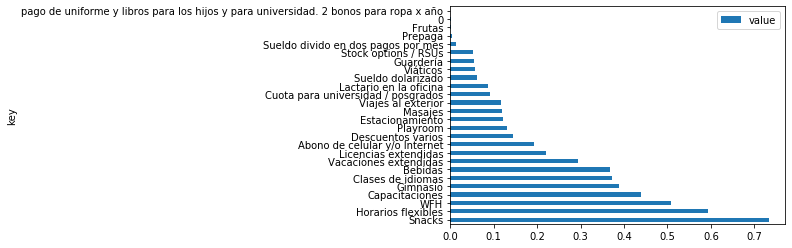

In [79]:
df = dataframe['beneficios_extra'].str.extractall(r"(?P<value>[^,]+),? ?")['value'].value_counts(normalize=False, sort=True).to_frame().rename_axis('key')
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(df, 'key', {
    '.*Vacaciones flexibles.*$': 'Vacaciones extendidas',
    '.*Licencias?.*$': 'Licencias extendidas',
    'horarios? flexibles?$': 'Horarios flexibles',
    '(.*capacitaci[oó]n(es)?.*|.*cursos?.*)$': 'Capacitaciones',
    'bebidas?$': 'Bebidas',
    '(golosinas?|snac?ks?)$': 'Snacks',
    '(Descuentos varios \(Clarín 365)$': 'Descuentos varios',
    '(etc\)|Club La Nación)$': 'DELETEME',
    '(no|.*Nada.*|Ning[uú]n[ao]?( de las anteriores)?)$': 'DELETEME',
    '(.*prepaga.*|OSDE|.*obra social.*)$': 'Prepaga',
    '(frut[ao]s?)$': 'Frutas',
    '(facturas?)': 'Facturas',
    '(.*home off?ice.*|.*WFH.*|.*home work.*)$': 'WFH',
    '(.*d[oó]lares.*|Sueldo dolarizado)$': 'Sueldo dolarizado',
    '(.*gimnasio.*|.*gym.*)$': 'Gimnasio',
    '(.*cochera.*|.*estacionamiento.*)$': 'Estacionamiento',
    '(.*combustibles?.*|.*vi[aá]ticos?.*|.*cabify.*|.*transporte.*|.*remis.*)$': 'Viáticos',
    '(.*sueldos? ex.*)$': 'Sueldos extra',
    '(.*eventos?.*|entradas?)$': 'Eventos',
    '(.*pileta)$': 'Pileta',
})

# Reagrupamos valores, sumándolos, luegode haber normalizado
df = df.query('key != "DELETEME"').groupby('key').sum()['value'].sort_values(ascending=False).to_frame() / len(dataframe)

df[:26].plot.barh()
charts['beneficios_extra'] = to_rechart(df[:26])

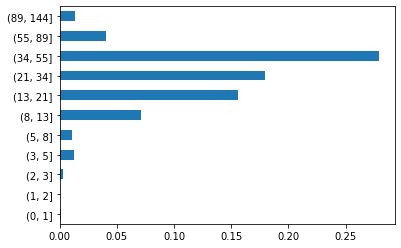

In [80]:
df = dataframe['de_que_fue_el_ajuste_total'].copy()
df = df.groupby(pd.cut(df.values, [0,1,2,3,5,8,13,21,34,55,89,144])).count()/len(df)

df.plot.barh()
charts['de_que_fue_el_ajuste'] = to_rechart(df.sort_index())

#### 2.5.3. Características de la Empresa

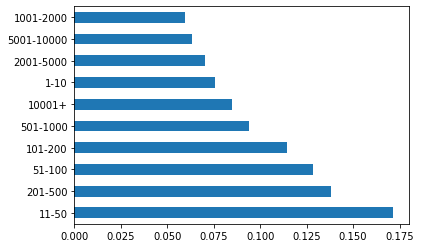

In [81]:
df = dataframe['cantidad_de_empleados'].value_counts(normalize=True, sort=True)

df.plot(kind='barh', logx=False);
charts['cantidad_de_empleados'] = to_rechart(df)

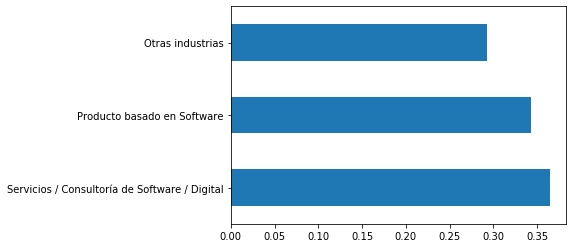

In [82]:
df = dataframe['actividad_principal'].value_counts(normalize=True, sort=True)

df.plot(kind='barh', logx=False);
charts['actividad_principal'] = to_rechart(df)

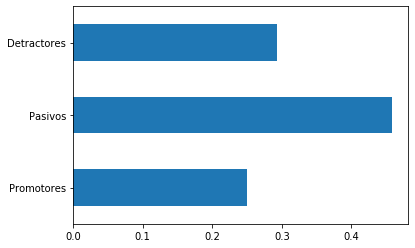

In [83]:
df = dataframe['la_recomendas_como_un_buen_lugar_para_trabajar'].copy()
# https://es.wikipedia.org/wiki/Net_Promoter_Score
df = df.groupby(pd.cut(df.values, [0,6,8,10], labels=['Detractores', 'Pasivos', 'Promotores'])).count()/len(df)
df = df.iloc[::-1] # reverse order

df.plot.barh()
charts['la_recomendas_como_un_buen_lugar_para_trabajar'] = to_rechart(df)

'reduced in 0.170695'

,value
key,
MercadoLibre,0.115365
Medallia,0.054214
MuleSoft,0.042652
Despegar,0.022610
Globant,0.021326
Google,0.020041
Auth0,0.014132
Accenture,0.013875
ASAPP,0.011305


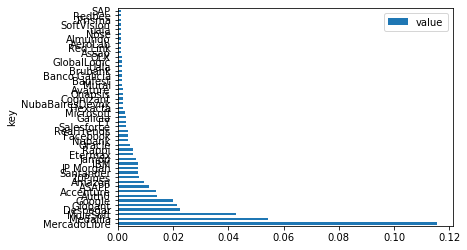

In [84]:
df = dataframe['cuales_consideras_que_son_las_mejores_empresas_de_it_para_trabajar_en_este_momentoen_tu_ciudad'].str.extractall(r"(?P<value>[^,]+),? ?")['value'].value_counts(normalize=False, sort=True).to_frame().rename_axis('key')
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(df, 'key', {
    '^(ningun[ao]|-|no lo se|desconozco|ni idea|no s[ée]|Son todas una mierda\.|bancos?)$': 'DELETEME',
    '^(mercadolibre|mercado libre|meli|ml|mercado ?pago)$': 'MercadoLibre',
    '^(medallia|medalia)$': 'Medallia',
    '^(despegar\.?(com)?)$': 'Despegar',
    '^(mulesoft)$': 'Mulesoft',
    '^(globant)$': 'Globant',
    '^(google)$': 'Google',
    '^(auth0)$': 'Auth0',
    '^(rappi)$': 'Rappi',
    '^(jampp?)$': 'Jampp',
    '^(asapp|asap)$': 'ASAPP',
    '^(ibm|i\.b\.m\.?)$': 'IBM',
    '^(aws|amazon)$': 'Amazon',
    '^(eventbrite)$': 'Eventbrite',
    '^(saleforce|salesforce)$': 'Salesforce',
    '^(olx|o\.l\.x\.?)$': 'OLX',
    '^(10 ?pines)$': '10Pines',
    '^(microsoft)$': 'Microsoft',
    '^(jp ?morgan)$': 'JP Morgan',
    '^(elementum)$': 'Elementum',
    '^(bell?atrix)$': 'Belatrix',
    '^(nubank)$': 'Nubank',
    '^(etermax)$': 'Etermax',
    '^(facebook)$': 'Facebook',
    '^(hexacta)$': 'Hexacta',
    '^(oracle)$': 'Oracle',
    '^(avature)$': 'Avature',
    '^(everis)$': 'Everis',
    '^(baires ?dev)$': 'NubaBairesDevnk',
    '^(stensul)$': 'Stensul',
    '^(satel? ?logic\.?)$': 'Satellogic',
    '^(scale)$': 'Scale',
    '^(aerolab)$': 'AeroLab',
    '^(rga|r/ga)$': 'R/GA',
    '^(accenture)$': 'Accenture',
    '^(olapic)$': 'Olapic',
    '^(logicalis)$': 'Logicalis',
    '^(mule ?(soft)?)$': 'MuleSoft',
    '^(soft ?vision)$': 'SoftVision',
    '^(global ?logic)$': 'GlobalLogic',
    '^(pedidos ?ya)$': 'PedidosYa',
    '^(decentra ?land)$': 'DecentraLand',
    '^(real ?trends)$': 'RealTrends',
    '^(nubi ?lmetri(x|cs))$': 'Nubimetrics',
    '^(santander( tec.*))$': 'Santander',
})

# Reagrupamos valores, sumándolos, luegode haber normalizado
df = df.query('key != "DELETEME"').groupby('key').sum()['value'].sort_values(ascending=False).to_frame() / len(dataframe)
display(df[:47])
df[:47].plot.barh()

## 3. Publicación

In [89]:
import json

# formateamos valores flotantes para ahorrar caracteres (#macritips)
with open('/Users/clrnd/Src/openqube-sueldos/src/components/Landing/charts.js', 'w') as f:
    f.write('export default JSON.parse(\n')
    f.write("'" + json.dumps(json.loads(json.dumps(charts, allow_nan=False), parse_float=lambda x: round(float(x), 5))) + "'")
    f.write(');\n')